# Drought Identification and Trend Analysis - Admin 2 Level

Author - Nitin Magima

Date - Oct 2024

Version - 1.0

The Jupyter Notebook uses the following [paper](https://www.mdpi.com/2071-1050/13/3/1042) to recreate the analysis for drought identification and trend analysis in Kenya using Google Earth Engine (GEE) for Python, follow these steps:

#### Data Collection

Obtain long-term satellite-derived precipitation data using the CHIRPS dataset available in GEE. This data will allow you to analyze drought conditions in Kenya.

#### Study Area Definition

Kenya's Boundaries: Define the study area by using Kenya's geographical boundaries.

#### Data Preprocessing

Extract Monthly Precipitation: Extract monthly CHIRPS precipitation data for the study area to calculate Standardized Precipitation Index (SPI) at different time scales (e.g., SPI1, SPI3, SPI6, SPI12).
Clip to Region: Clip the precipitation data to the Kenya boundaries to ensure that the analysis is focused solely on Kenya. This is already been done usng GEE.

#### Calculate Standardized Precipitation Index (SPI)

SPI Calculation: Calculate SPI at different time scales (1-, 3-, 6-, and 12-month) for drought evaluation. Convert the CHIRPS precipitation data into SPI values by fitting a gamma distribution to each pixel's monthly time series.

#### Drought Characterization

Identify Drought Events: Use run theory to identify drought events based on SPI values. Define the drought duration, severity, and intensity by analyzing when SPI values fall below thresholds like -1.0 for moderate drought.
Identify drought duration (number of months below the threshold).
Calculate drought severity (sum of all SPI values during the drought).
Calculate drought intensity (severity divided by duration).

#### Trend Analysis

Mann-Kendall Test: Implement the Mann-Kendall trend test to determine trends in SPI values at annual, seasonal, and monthly time scales. This will help detect if there are increasing or decreasing trends in drought conditions.
Apply Sen’s slope estimator to understand the magnitude of trends.

#### EM-DAT Analysis

Use historical drought years from the [Emergency Events Database (EM-DAT)](https://www.emdat.be/) for comparison.


### DISCLAIMER

This is a set of scripts  shared for educational purposes only.  Anyone who uses this code or its
functionality or structure, assumes full liability and credits the author.

#### Map Disclaimer

The designations employed and the presentation of the material on this map do not imply the expression 
of any opinion whatsoever on the part of the author concerning the legal status of any country, territory, city or area or of its authorities, or concerning the delimitation of its 
frontiers or boundaries.


### Import libraries

In [1]:
pip install pymannkendall

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
from scipy.stats import gamma, norm, kstest, probplot
import time
import matplotlib.pyplot as plt
from ipywidgets import interact, Dropdown, fixed, widgets, Checkbox, RadioButtons 
import pymannkendall as mk
import json
import geopandas as gpd
import seaborn as sns

# Define Analysis Boundaries

We use the following [crop calendar](https://fews.net/sites/default/files/styles/large_width_880/public/2023-03/seasonal-calendar-kenya.png?itok=0Wob_hCK) to select the regions and time periods to focus on.

We define boundaries for the Western and Rift Valley, and Eastern and Northern Kenya. We use the [FAO GAUL: Global Administrative Unit Layers](https://data.apps.fao.org/catalog/dataset/global-administrative-unit-layers-gaul) from [**Google Earth Engine (GEE)**](https://earthengine.google.com/) for the analysis.

GEE is a public data archive of petabytes of historical satellite imagery and geospatial datasets. The advantage lies in its remarkable computation speed as processing is outsourced to Google servers. The platform provides a variety of constantly updated datasets; no download of raw imagery is required. While it is free of charge, one still needs to activate access to Google Earth Engine with a valid Google account.

The Global Administrative Unit Layers (GAUL) compiles and disseminates the best available information on administrative units for all the countries in the world, providing a contribution to the standardization of the spatial dataset representing administrative units. The GAUL always maintains global layers with a unified coding system at country, first (e.g. departments), and second administrative levels (e.g. districts). Where data is available, it provides layers on a country by country basis down to third, fourth, and lowers levels.

# Load CHIRPS Pentad Dataset

# Define Time Period

The periods of interest are the planting, harvest, and rain seasons for different regions of Kenya. We will use these timelines to define the start and end dates for creating the relevant dekadal (10-day period) analysis from the CHIRPS pentad data.

1. Western and Rift Valley  

- Long Rains: March to June
- Planting: April to June
- Long Rains Harvest: July to August & October to November

2. Eastern and Northern Kenya:

- Short Rains Harvest: February to March
- Planting: March to May
- Long Rains: March to June
- Lean Season: September to November
- Short Rains: October to December

Based on this calendar, we'll use the start and end months for rainfall using the CHIRPS Pentad dataset ('UCSB-CHG/CHIRPS/PENTAD').

In [3]:
# This loaded dataframe is created using GEE  
combined_df = pd.read_csv("data/kenya_admin1_precip.csv")

# Western and Rift Valley region long rains
western_rift_long_rains_df = combined_df[
    (combined_df['region'] == 'Western and Rift Valley') &
    (combined_df['Season'] == 'Long Rain')
]

# Eastern and Northern region long rains
eastern_northern_long_rains_df = combined_df[
    (combined_df['region'] == 'Eastern and Northern Kenya') &
    (combined_df['Season'] == 'Long Rain')
]

# Eastern and Northern region short rains
eastern_northern_short_rains_df = combined_df[
    (combined_df['region'] == 'Eastern and Northern Kenya') &
    (combined_df['Season'] == 'Short Rain')
]

In [4]:
eastern_northern_long_rains_df

,Unnamed: 0,year,month,date,region,precipitation,Season
96,0,2000,3,2000-03-01T00:00:00,Eastern and Northern Kenya,13.402781,Long Rain
97,1,2000,4,2000-04-01T00:00:00,Eastern and Northern Kenya,45.300236,Long Rain
98,2,2000,5,2000-05-01T00:00:00,Eastern and Northern Kenya,24.638043,Long Rain
99,3,2000,6,2000-06-01T00:00:00,Eastern and Northern Kenya,5.139533,Long Rain
100,4,2001,3,2001-03-01T00:00:00,Eastern and Northern Kenya,48.436902,Long Rain
...,...,...,...,...,...,...,...
187,91,2022,6,2022-06-01T00:00:00,Eastern and Northern Kenya,4.953991,Long Rain
188,92,2023,3,2023-03-01T00:00:00,Eastern and Northern Kenya,91.669711,Long Rain
189,93,2023,4,2023-04-01T00:00:00,Eastern and Northern Kenya,216.350597,Long Rain
190,94,2023,5,2023-05-01T00:00:00,Eastern and Northern Kenya,23.780429,Long Rain


# Calculate Standardized Precipitation Index (SPI)

## SPI Definitions

* SPI1 (1-month scale)

Used to capture short-term monthly precipitation fluctuations and early warning of meteorological drought.

* SPI3 (3-month scale)

Useful for seasonal drought analysis, which helps in understanding the drought conditions over a quarterly period, closely related to agricultural impacts.

* SPI6 (6-month scale)

Provides insights into medium-term drought conditions, capturing both the end of one season and the start of another, which can influence soil moisture and crop yield over a longer period.

* SPI12 (12-month scale)

Used to assess long-term drought conditions, representing annual fluctuations and providing insights into the overall hydrological drought scenario, which can affect groundwater recharge and surface water availability.


## Selecting SPI Time Scales
Based on the above definitions we select the following time Scales for Long and Short Rains:

- Long Rains: March to June (4-month period) - We will use 1-month and 3-month SPI for long rains to understand short-term and medium-term droughts.
- Short Rains: October to December (3-month period) - We will use 1-month and 3-month SPI to capture variability within the shorter rainy season.

## Determining Gamma Distribution

What is a Gamma Distribution?

A gamma distribution is a type of statistical model used to describe data that are always positive and usually skewed, meaning most values are small but there can be a few large values. It's often used for things like rainfall, where:

- Many days have little or no rain, and
- A few days have a lot of rain.

This type of pattern creates a graph that has a high peak near the small values and a long tail extending to larger values. That’s what the gamma distribution looks like.

Why Do We Use Gamma Distribution for Rainfall?

- Always Positive: Rainfall cannot be negative; it either doesn’t rain or it rains some amount. The gamma distribution is great for representing only positive values.
- Right-Skewed Data: Most of the time, we have small amounts of rainfall, and occasionally, we get heavy rainfall. The gamma distribution is good for representing this kind of uneven distribution.
- Flexibility: The shape of the gamma distribution can change to fit different types of rainfall patterns, making it a very flexible tool for modeling different weather conditions.

The Gamma Distribution is the Standardized Precipitation Index (SPI) as a way to figure out if a place is having normal, dry, or wet weather compared to its history. 

1. Modeling Historical Rainfall:

We use the gamma distribution to fit the historical rainfall data. This helps us understand what the usual rainfall is like for each month.

2. Comparing to Current Rainfall:

Once we have the gamma model of typical rainfall, we compare current rainfall to see how much it differs from the usual.
This comparison tells us if it is drier or wetter than normal, and by how much.

3. Getting SPI:

The final step is to convert this difference into a number called SPI, which tells us:
- If the SPI is negative, it means it’s drier than usual (possible drought).
- If the SPI is positive, it means it’s wetter than usual (possible flooding).

### Histograms

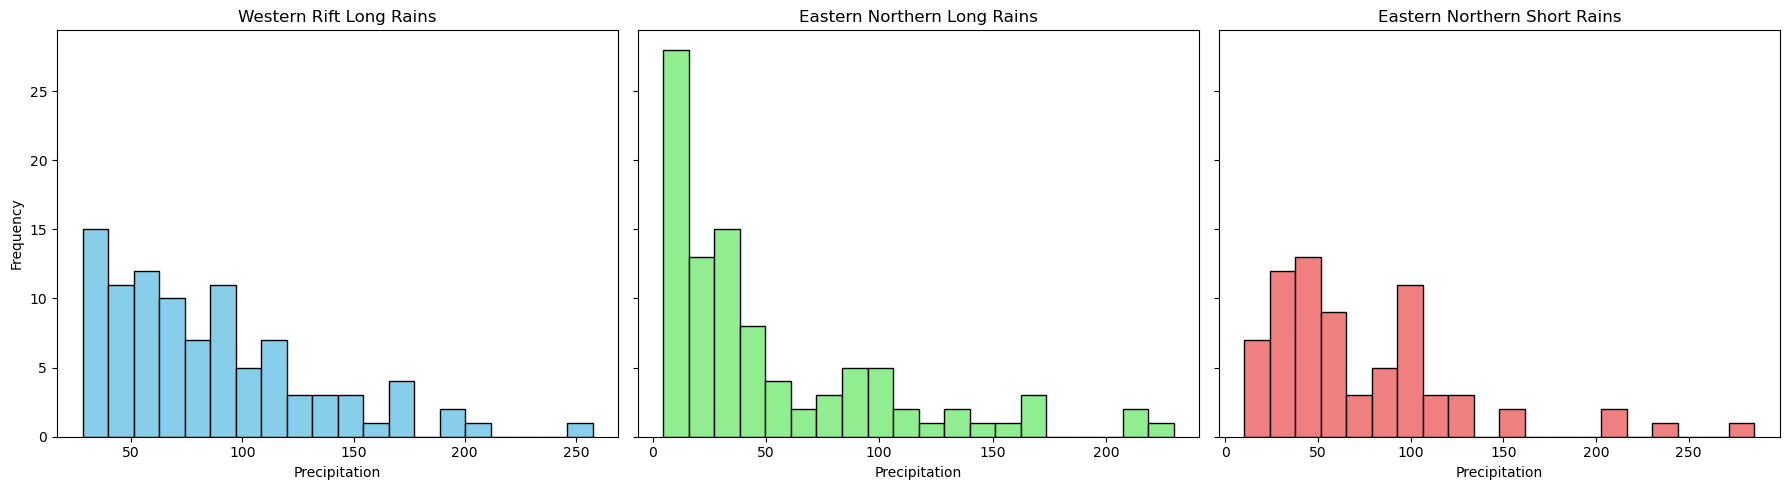

In [5]:
# Plot histograms for each dataset
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

axes[0].hist(western_rift_long_rains_df['precipitation'], bins=20, color='skyblue', edgecolor='black')
axes[0].set_title('Western Rift Long Rains')
axes[0].set_xlabel('Precipitation')
axes[0].set_ylabel('Frequency')

axes[1].hist(eastern_northern_long_rains_df['precipitation'], bins=20, color='lightgreen', edgecolor='black')
axes[1].set_title('Eastern Northern Long Rains')
axes[1].set_xlabel('Precipitation')

axes[2].hist(eastern_northern_short_rains_df['precipitation'], bins=20, color='lightcoral', edgecolor='black')
axes[2].set_title('Eastern Northern Short Rains')
axes[2].set_xlabel('Precipitation')

plt.tight_layout()
plt.show()

### Kolmogorov-Smirnov Test

Understanding the Kolmogorov-Smirnov Test:
The Kolmogorov-Smirnov test compares the empirical distribution of your data to a theoretical distribution (in this case, the gamma distribution).
The null hypothesis (H₀) of the KS test is that the data follows the specified distribution (in this case, gamma).
The alternative hypothesis (H₁) is that the data does not follow the specified distribution.

In the context of the Kolmogorov-Smirnov (KS) test, a p-value greater than 0.05 is typically desired when checking the fit of a distribution.

Interpreting the p-value:

- p-value > 0.05:
If the p-value is greater than 0.05, it means there is insufficient evidence to reject the null hypothesis.
In other words, the data fits the gamma distribution well. Therefore, we accept the null hypothesis and conclude that the gamma distribution is likely a good fit.

- p-value < 0.05:
If the p-value is less than 0.05, it means that there is significant evidence to reject the null hypothesis.
This suggests that the gamma distribution may not be a good fit for the data.

In [6]:
# Kolmogorov-Smirnov test to check if the gamma distribution fits each dataset.
def perform_ks_test(data):
    # Fit a gamma distribution to the data
    shape, loc, scale = gamma.fit(data, floc=0)  # floc=0 to ensure non-negative values

    # Perform Kolmogorov-Smirnov test
    test_stat, p_value = kstest(data, gamma(shape, loc, scale).cdf)

    # Print results
    if p_value > 0.05:
        print("The data fits the gamma distribution well (p-value: {:.4f}).".format(p_value))
    else:
        print("The gamma distribution may not be the best fit (p-value: {:.4f}).".format(p_value))

# Perform KS test for each dataset
print("Western Rift Long Rains:")
perform_ks_test(western_rift_long_rains_df['precipitation'].dropna())

print("\nEastern Northern Long Rains:")
perform_ks_test(eastern_northern_long_rains_df['precipitation'].dropna())

print("\nEastern Northern Short Rains:")
perform_ks_test(eastern_northern_short_rains_df['precipitation'].dropna())

Western Rift Long Rains:
The data fits the gamma distribution well (p-value: 0.4967).

Eastern Northern Long Rains:
The data fits the gamma distribution well (p-value: 0.2442).

Eastern Northern Short Rains:
The data fits the gamma distribution well (p-value: 0.6800).


### QQ Plots

A QQ plot, or Quantile-Quantile plot, is a graphical tool used to compare the distribution of a dataset with a theoretical distribution, such as the normal or gamma distribution. It's a provides a visual assessment of how well the dataset fits a chosen probability distribution. The QQ plot compares the quantiles of the dataset with the quantiles of the specified theoretical distribution.

If the data follows the theoretical distribution closely, the points on the plot will align approximately along a straight line. Deviations from this line indicate that the data does not conform well to the expected distribution.

In [7]:
# Visualize the Fit Using QQ Plots

# Assign Datasets
data_dict = {
    'Western Rift Long Rains': western_rift_long_rains_df['precipitation'].dropna(),
    'Eastern Northern Long Rains': eastern_northern_long_rains_df['precipitation'].dropna(),
    'Eastern Northern Short Rains': eastern_northern_short_rains_df['precipitation'].dropna()
}

def interactive_qq_plot(region_time_scale):
    """
    Generates a QQ plot for the selected dataset using a gamma distribution.
    
    Parameters:
    region_time_scale (str): The key to select the dataset from the data dictionary.
    """
    # Extract the data series from the dictionary based on the selected region and time scale
    data = data_dict[region_time_scale]

    # Fit the gamma distribution
    shape, loc, scale = gamma.fit(data, floc=0)

    # Generate QQ plot
    plt.figure(figsize=(8, 6))
    probplot(data, dist="gamma", sparams=(shape, loc, scale), plot=plt)
    plt.title(f"QQ Plot to Check Gamma Fit: {region_time_scale}")
    plt.xlabel("Theoretical Quantiles")
    plt.ylabel("Ordered Values")
    plt.grid(True)
    plt.show()

# Create an interactive dropdown widget for selecting the region and time scale
interact(
    interactive_qq_plot,
    region_time_scale=Dropdown(
        options=list(data_dict.keys()),
        description='Select Region & Time Scale:',
        style={'description_width': 'initial'},
    )
)


interactive(children=(Dropdown(description='Select Region & Time Scale:', options=('Western Rift Long Rains', …

<function __main__.interactive_qq_plot(region_time_scale)>

## Calculate SPI

In [8]:
# Combine all datasets
all_rains_df = pd.concat([
    western_rift_long_rains_df,
    eastern_northern_long_rains_df,
    eastern_northern_short_rains_df
])

# Convert the 'date' column to datetime
all_rains_df['date'] = pd.to_datetime(all_rains_df['date'])

# Set the 'date' as the index for easier time series operations
all_rains_df.set_index('date', inplace=True)

# Sort the data by index
all_rains_df.sort_index(inplace=True)

def calculate_spi(precip_series, scale=1):
    """
    Calculate Standardized Precipitation Index (SPI) for a given precipitation series.

    Parameters:
    precip_series (pd.Series): Monthly precipitation data.
    scale (int): Time scale over which to calculate SPI (e.g., 1-month, 3-month).

    Returns:
    pd.Series: SPI values for the given precipitation series.
    """
    # Calculate rolling sum over the specified time scale
    precip_rolling = precip_series.rolling(window=scale).sum()

    # Drop NaN values resulting from the rolling operation
    precip_rolling = precip_rolling.dropna()

    # Fit a gamma distribution to the rolling sum data
    shape, loc, scale_param = gamma.fit(precip_rolling, floc=0)

    # Calculate cumulative distribution function (CDF) for gamma distribution
    gamma_cdf = gamma.cdf(precip_rolling, shape, loc=loc, scale=scale_param)

    # Convert gamma CDF to standard normal distribution to calculate SPI
    spi_values = norm.ppf(gamma_cdf)

    # Return the SPI values as a pandas Series with the same index as the rolling sum
    return pd.Series(spi_values, index=precip_rolling.index)

# Prepare the data by grouping it by region and calculating SPI for each region separately
regions = all_rains_df['region'].unique()
spi_results = {}

for region in regions:
    region_data = all_rains_df[all_rains_df['region'] == region]['precipitation']

    # Calculate 1-month SPI
    spi_1_month = calculate_spi(region_data, scale=1)
    spi_results[f'{region}_1_month'] = spi_1_month

    # Calculate 3-month SPI
    spi_3_month = calculate_spi(region_data, scale=3)
    spi_results[f'{region}_3_month'] = spi_3_month

# Convert SPI results to DataFrame
spi_results_df = pd.DataFrame(spi_results)

# Display SPI results for long rains and short rains
print("SPI Results for Long and Short Rains:")
print(spi_results_df.head())

SPI Results for Long and Short Rains:
            Western and Rift Valley_1_month  Western and Rift Valley_3_month  \
date                                                                           
2000-03-01                        -1.331302                              NaN   
2000-04-01                        -0.640390                              NaN   
2000-05-01                        -0.763152                        -1.729256   
2000-06-01                        -1.284969                        -1.707764   
2000-10-01                              NaN                              NaN   

            Eastern and Northern Kenya_1_month  \
date                                             
2000-03-01                           -1.061007   
2000-04-01                           -0.019835   
2000-05-01                           -0.584277   
2000-06-01                           -1.685381   
2000-10-01                           -0.480184   

            Eastern and Northern Kenya_3_month  
d

In [9]:
# Interactive plotting function
def plot_spi(region_time_scale):
    # Extract the SPI series based on the selected region and time scale
    spi_series = spi_results_df[region_time_scale].dropna()

    # Plot the SPI values
    plt.figure(figsize=(10, 6))
    plt.plot(spi_series.index, spi_series, color='blue', linestyle='-', marker='o', label='SPI')
    plt.axhline(y=0, color='black', linestyle='--')  # Reference line at SPI=0
    plt.axhline(y=-1, color='red', linestyle='--', label='Mild Drought (SPI=-1)')
    plt.axhline(y=-1.5, color='orange', linestyle='--', label='Moderate Drought (SPI=-1.5)')
    plt.axhline(y=-2, color='darkred', linestyle='--', label='Severe Drought (SPI=-2)')
    
    plt.xlabel('Date')
    plt.ylabel('SPI Value')
    plt.title(f'Standardized Precipitation Index (SPI) for {region_time_scale}')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Get the list of region_time_scale options from the DataFrame columns
region_time_scale_options = spi_results_df.columns.tolist()

# Create a dropdown widget for selecting the region and time scale
interact(
    plot_spi,
    region_time_scale=Dropdown(
        options=region_time_scale_options,
        description='Select Region & Scale:',
        style={'description_width': 'initial'},
    )
)

interactive(children=(Dropdown(description='Select Region & Scale:', options=('Western and Rift Valley_1_month…

<function __main__.plot_spi(region_time_scale)>

## Identify Drought Events

To characterize droughts, we need to analyze the SPI values calculated previously to identify distinct drought events. This involves analyzing when SPI values fall below a threshold, like -1.0, to determine the duration, severity, and intensity of each drought event.

Definitions:

- Drought Event: A period during which SPI is below a defined threshold (e.g., SPI < -1.0 for moderate drought).
- Drought Duration: The number of months during which the SPI value stays below the threshold.
- Drought Severity: The sum of all SPI values during the drought period.
- Drought Intensity: Severity divided by duration, indicating how intense the drought is on average.

In [10]:
def characterize_drought_events(spi_series, threshold=-1.0):
    """
    Identify and characterize drought events based on SPI values.

    Parameters:
    spi_series (pd.Series): Series of SPI values indexed by date.
    threshold (float): Threshold SPI value below which a drought event is identified (default: -1.0).

    Returns:
    pd.DataFrame: DataFrame containing drought events with columns for start, end, duration, severity, and intensity.
    """
    drought_events = []
    in_drought = False
    start_date = None
    severity = 0

    # Loop through each SPI value to identify drought events
    for date, spi_value in spi_series.items():
        if spi_value < threshold:
            # If we are not already in a drought, mark the start
            if not in_drought:
                in_drought = True
                start_date = date
                severity = spi_value
            else:
                # Accumulate severity if already in a drought
                severity += spi_value
        else:
            # If we exit a drought, calculate duration, severity, and intensity
            if in_drought:
                in_drought = False
                end_date = date
                duration = (end_date - start_date).days // 30  # Approximate duration in months
                intensity = severity / duration if duration > 0 else 0
                drought_events.append({
                    'start_date': start_date,
                    'end_date': end_date,
                    'duration_months': duration,
                    'severity': severity,
                    'intensity': intensity
                })

    # Handle the case where a drought is ongoing at the end of the series
    if in_drought:
        end_date = spi_series.index[-1]
        duration = (end_date - start_date).days // 30
        intensity = severity / duration if duration > 0 else 0
        drought_events.append({
            'start_date': start_date,
            'end_date': end_date,
            'duration_months': duration,
            'severity': severity,
            'intensity': intensity
        })

    # Convert to DataFrame
    return pd.DataFrame(drought_events)

In [11]:
# Identify drought events for each region and time scale
drought_characteristics = {}

for column in spi_results_df.columns:
    spi_series = spi_results_df[column].dropna()
    drought_characteristics[column] = characterize_drought_events(spi_series)

# Display drought characteristics for "Western and Rift Valley" on a 1-month scale
print("Drought Characteristics for Western and Rift Valley (1-Month Scale):")
print(drought_characteristics['Western and Rift Valley_1_month'])

# Display drought characteristics for "Western and Rift Valley" on a 3-month scale
print("Drought Characteristics for Western and Rift Valley (3-Month Scale):")
print(drought_characteristics['Western and Rift Valley_3_month'])

# Display drought characteristics for "Eastern and Northern Kenya" on a 1-month scale
print("Drought Characteristics for Eastern and Northern Kenya (1-Month Scale):")
print(drought_characteristics['Eastern and Northern Kenya_1_month'])

# Display drought characteristics for "Eastern and Northern Kenya" on a 3-month scale
print("Drought Characteristics for Eastern and Northern Kenya (3-Month Scale):")
print(drought_characteristics['Eastern and Northern Kenya_3_month'])

Drought Characteristics for Western and Rift Valley (1-Month Scale):
   start_date   end_date  duration_months  severity  intensity
0  2000-03-01 2000-04-01                1 -1.331302  -1.331302
1  2000-06-01 2001-03-01                9 -1.284969  -0.142774
2  2002-06-01 2003-03-01                9 -1.235686  -0.137298
3  2004-06-01 2005-03-01                9 -1.525327  -0.169481
4  2005-06-01 2006-03-01                9 -1.122668  -0.124741
5  2006-06-01 2007-03-01                9 -1.209441  -0.134382
6  2008-06-01 2009-04-01               10 -2.777055  -0.277705
7  2009-06-01 2010-03-01                9 -1.643487  -0.182610
8  2012-03-01 2012-04-01                1 -1.303328  -1.303328
9  2015-03-01 2015-04-01                1 -1.330411  -1.330411
10 2017-03-01 2017-04-01                1 -1.192278  -1.192278
11 2017-06-01 2018-03-01                9 -1.317395  -0.146377
12 2019-03-01 2019-04-01                1 -1.210922  -1.210922
13 2021-03-01 2021-04-01                1 -1.1053

Note - The issue where drought durations exceed expected limits (e.g., durations exceeding 3 months for a "3-month SPI scale") arises from the way the drought characterization function is designed. Specifically, the function might be identifying prolonged drought events that span beyond a single season or multi-month drought events that are not being properly split when SPI values rise above the threshold.

Due to continuous negative SPI Values, the function currently identifies a drought event as continuing until the SPI rises above the threshold. If the SPI remains below the threshold for an extended period (even beyond a season), the function will count that entire period as a single drought event.

## Trend Analysis

The Mann-Kendall test is a non-parametric test used to identify trends in time series data. It is particularly useful for climate data, like SPI values, to determine if there's a significant increasing or decreasing trend in drought conditions over time. We will also use Sen’s slope estimator to determine the magnitude of the trends identified.

In [12]:
# Function to perform Mann-Kendall Test and Sen's Slope Estimation
def perform_trend_analysis(spi_series, time_scale):
    """
    Perform Mann-Kendall test and Sen's Slope Estimation for the given SPI series.

    Parameters:
    spi_series (pd.Series): Series of SPI values.
    time_scale (str): Time scale (e.g., 'annual', 'seasonal', 'monthly').

    Returns:
    dict: Dictionary containing trend, p-value, and Sen's slope.
    """
    # Drop NaN values
    spi_series = spi_series.dropna()

    # Perform Mann-Kendall Trend Test
    mk_result = mk.original_test(spi_series)

    # Extract trend, p-value, and Sen's slope
    trend = mk_result.trend
    p_value = mk_result.p
    sen_slope = mk_result.slope

    return {
        'time_scale': time_scale,
        'trend': trend,
        'p_value': p_value,
        'sen_slope': sen_slope
    }

In [13]:
# Applying the Mann-Kendall Test and Sen's Slope Estimation
trend_analysis_results = {}

# Perform trend analysis for different time scales
time_scales = {
    'Western and Rift Valley_1_month': 'monthly',
    'Western and Rift Valley_3_month': 'seasonal',
    'Eastern and Northern Kenya_1_month': 'monthly',
    'Eastern and Northern Kenya_3_month': 'seasonal'
}

# Loop through the SPI columns and apply trend analysis
for column, time_scale in time_scales.items():
    spi_series = spi_results_df[column]
    trend_analysis_results[column] = perform_trend_analysis(spi_series, time_scale)

# Convert results to DataFrame for better visualization
trend_analysis_df = pd.DataFrame(trend_analysis_results).T

# Display the trend analysis results
print("Trend Analysis Results (Mann-Kendall Test and Sen's Slope):")
print(trend_analysis_df)

Trend Analysis Results (Mann-Kendall Test and Sen's Slope):
                                   time_scale     trend   p_value sen_slope
Western and Rift Valley_1_month       monthly  no trend  0.441803  0.003217
Western and Rift Valley_3_month      seasonal  no trend  0.113907  0.006367
Eastern and Northern Kenya_1_month    monthly  no trend  0.507644  0.000977
Eastern and Northern Kenya_3_month   seasonal  no trend   0.18742  0.002108


# EM-DAT Analysis

In [14]:
pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


In [15]:
# Load the Excel file
file_path = 'data/public_emdat_custom_request_2024-10-01_36a9efba-9545-41bc-a272-3b49c638962b.xlsx'
excel_data = pd.ExcelFile(file_path)

# Display sheet names to understand the structure
sheet_names = excel_data.sheet_names

# Load the data from each sheet
emdat_data = pd.read_excel(excel_data, sheet_name='EM-DAT Data')
emdat_info = pd.read_excel(excel_data, sheet_name='EM-DAT Info')

# Clean the 'EM-DAT Data' sheet by dropping unnecessary columns and handling missing values
# Drop columns that seem unnecessary for analysis
columns_to_drop = [
    'External IDs', 'Event Name', 'Reconstruction Costs (\'000 US$)', 'Classification Key',
    'Reconstruction Costs, Adjusted (\'000 US$)', 'Insured Damage (\'000 US$)',
    'Insured Damage, Adjusted (\'000 US$)', 'Total Damage (\'000 US$)', 'No. Injured',
    'Total Damage, Adjusted (\'000 US$)', 'Entry Date', 'Last Update', 'No. Homeless', 'Disaster Group', 
    'Disaster Subgroup', 'Disaster Type', 'Disaster Subtype', 'ISO', 'Country', 'Subregion', 'Region',
    'OFDA/BHA Response', 'Appeal', 'Declaration', "AID Contribution ('000 US$)",
    'Magnitude', 'Magnitude Scale', 'Latitude',	'Longitude', 'River Basin', 'Start Day', 'End Day'
]

emdat_data = emdat_data.drop(columns=columns_to_drop)

# Reset the index for a clean DataFrame
emdat_data.reset_index(drop=True, inplace=True)

# Separate the values in the 'Location' column into multiple columns

# Split the 'Location' column into multiple columns
location_split = emdat_data['Location'].str.split(',', expand=True)

# Rename the new columns as 'Location_1', 'Location_2', etc.
location_split.columns = [f'Location_{i+1}' for i in range(location_split.shape[1])]

# Concatenate the original dataframe with the new location columns
emdat_data = pd.concat([emdat_data.drop(columns=['Location']), location_split], axis=1)

# Separate the values in the 'Admin Units' column into multiple columns
# Assuming 'Admin Units' is in JSON format; parsing and normalizing it
admin_units_split = emdat_data['Admin Units'].apply(lambda x: pd.json_normalize(eval(x)) if pd.notna(x) else pd.DataFrame())

# Concatenate the parsed 'Admin Units' data into a single DataFrame
admin_units_expanded = pd.concat(admin_units_split.tolist(), ignore_index=True)

# Rename the columns appropriately as 'Admin_Unit_1', 'Admin_Unit_2', etc.
admin_units_expanded.columns = [f'Admin_Unit_{col}' for col in admin_units_expanded.columns]

# Concatenate the original dataframe with the new admin unit columns
emdat_data = pd.concat([emdat_data.drop(columns=['Admin Units']), admin_units_expanded], axis=1)

# Melt the dataset to create a 'Location' column from the separated location columns
# Identifying the id_vars (columns that should remain fixed) and value_vars (columns to unpivot)
id_vars = [col for col in emdat_data.columns if not col.startswith('Location_')]
value_vars = [col for col in emdat_data.columns if col.startswith('Location_')]

# Melting the dataset
emdat_data = pd.melt(
    emdat_data,
    id_vars=id_vars,
    value_vars=value_vars,
    var_name='Location_Number',
    value_name='Location'
)

# Drop rows where 'Location' is NaN (since these are redundant after melting)
emdat_data = emdat_data.dropna(subset=['Location']).reset_index(drop=True)

# Strip the white space from the 'Location' column
emdat_data['Location'] = emdat_data['Location'].str.strip()

# Drop the 'Location_Number' column
emdat_data = emdat_data.drop(columns=['Location_Number', 'Admin_Unit_adm1_code', 'Admin_Unit_adm2_code'])

# Creating a dictionary mapping for the locations to their corresponding admin 1 regions
location_to_admin1_dict = {
    'Kilifi': 'Coast',
    'Kwale': 'Coast',
    'Malindi': 'Coast',
    'Taita Taveta': 'Coast',
    'Tana River': 'Coast',
    'Kitui': 'Eastern',
    'Marsabit': 'Eastern'
}

# Map the 'Admin_Unit_adm2_name' to 'Admin_Unit_adm1_name' using the dictionary
emdat_data['Admin_Unit_adm1_name'] = emdat_data['Admin_Unit_adm2_name'].map(location_to_admin1_dict)

# Drop rows where the value of "Admin_Unit_adm1_name" is "Coast"
emdat_data = emdat_data[emdat_data['Admin_Unit_adm1_name'] != 'Coast'].reset_index(drop=True)

# Display the updated DataFrame with the mapped admin 1 regions
emdat_data

,DisNo.,Historic,Origin,Associated Types,Start Year,Start Month,End Year,End Month,Total Deaths,No. Affected,Total Affected,CPI,Admin_Unit_adm1_name,Admin_Unit_adm2_name,Location
0,2004-9288-KEN,No,Poor rainfall,Crop failure|Food shortage,2004.0,7.0,2004.0,NaN,80.0,2300000.0,2300000.0,61.989586,NaN,NaN,Kitui
1,2005-9719-KEN,No,Lack of rains,Famine,2005.0,12.0,2006.0,NaN,27.0,3500000.0,3500000.0,64.092740,NaN,NaN,Makueni
2,2019-9145-KEN,No,Two consecutive poor rainy seasons,Food shortage,2019.0,1.0,2019.0,9.0,NaN,2600000.0,2600000.0,83.904170,Eastern,Kitui,West Pokot
3,2020-9609-KEN,No,Lack of rains,Food shortage,2020.0,12.0,2022.0,12.0,NaN,4500000.0,4500000.0,84.939198,Eastern,Marsabit,Marsabit
4,2004-9288-KEN,No,Poor rainfall,Crop failure|Food shortage,2004.0,7.0,2004.0,NaN,80.0,2300000.0,2300000.0,61.989586,NaN,NaN,Mbeere
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,2005-9719-KEN,No,Lack of rains,Famine,2005.0,12.0,2006.0,NaN,27.0,3500000.0,3500000.0,64.092740,NaN,NaN,Kajiado
61,2004-9288-KEN,No,Poor rainfall,Crop failure|Food shortage,2004.0,7.0,2004.0,NaN,80.0,2300000.0,2300000.0,61.989586,NaN,NaN,Central provinces
62,2005-9719-KEN,No,Lack of rains,Famine,2005.0,12.0,2006.0,NaN,27.0,3500000.0,3500000.0,64.092740,NaN,NaN,Turkana
63,2005-9719-KEN,No,Lack of rains,Famine,2005.0,12.0,2006.0,NaN,27.0,3500000.0,3500000.0,64.092740,NaN,NaN,Samburu


In [16]:
# Get the unique pairings between "Start Year" and "End Year"
unique_year_pairings = emdat_data[['Start Year', 'End Year']].dropna().drop_duplicates().reset_index(drop=True)

# Display the unique pairings
unique_year_pairings

,Start Year,End Year
0,2004.0,2004.0
1,2005.0,2006.0
2,2019.0,2019.0
3,2020.0,2022.0
